In [10]:
from google.colab import drive
drive.mount ('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [109]:
#Sale Predictions of Food Items
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import sklearn.metrics as metrics
from sklearn.tree import DecisionTreeRegressor
import matplotlib.ticker as mticker
from xgboost import plot_importance
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from math import sqrt
from sklearn.impute import SimpleImputer




sales_data = '/content/sales_predictions.csv'  #source: https://datahack.analyticsvidhya.com/contest/practice-problem-big-mart-sales-iii/
df = pd.read_csv(sales_data)
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [13]:
df.shape #1 (#rows, #columns)

(8523, 12)

In [14]:
df.dtypes #2 data types of each variable

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

In [15]:
#3 Are there any duplicates? no
df.duplicated().sum() #look for duplicated rows and total the number of duplicates

0

In [16]:
#4 Are there any missing values? yes
df.isna().sum() #Total number of missing values in each column


Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [17]:
df.isna().any()[lambda x: x] 

Item_Weight    True
Outlet_Size    True
dtype: bool

In [18]:
df.loc[df.isnull().any(axis=1)] #locate rows with missing values

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
7,FDP10,NaN,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636
8,FDH17,16.20,Regular,0.016687,Frozen Foods,96.9726,OUT045,2002,NaN,Tier 2,Supermarket Type1,1076.5986
9,FDU28,19.20,Regular,0.094450,Frozen Foods,187.8214,OUT017,2007,NaN,Tier 2,Supermarket Type1,4710.5350
18,DRI11,NaN,Low Fat,0.034238,Hard Drinks,113.2834,OUT027,1985,Medium,Tier 3,Supermarket Type3,2303.6680
...,...,...,...,...,...,...,...,...,...,...,...,...
8504,NCN18,NaN,Low Fat,0.124111,Household,111.7544,OUT027,1985,Medium,Tier 3,Supermarket Type3,4138.6128
8508,FDW31,11.35,Regular,0.043246,Fruits and Vegetables,199.4742,OUT045,2002,NaN,Tier 2,Supermarket Type1,2587.9646
8509,FDG45,8.10,Low Fat,0.214306,Fruits and Vegetables,213.9902,OUT010,1998,NaN,Tier 3,Grocery Store,424.7804
8514,FDA01,15.00,Regular,0.054489,Canned,57.5904,OUT045,2002,NaN,Tier 2,Supermarket Type1,468.7232


In [19]:
df_nullWeights= df.loc[df['Item_Weight'].isnull()] #locate rows where Item_Weights are missing
df_nullWeights

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
7,FDP10,NaN,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636
18,DRI11,NaN,Low Fat,0.034238,Hard Drinks,113.2834,OUT027,1985,Medium,Tier 3,Supermarket Type3,2303.6680
21,FDW12,NaN,Regular,0.035400,Baking Goods,144.5444,OUT027,1985,Medium,Tier 3,Supermarket Type3,4064.0432
23,FDC37,NaN,Low Fat,0.057557,Baking Goods,107.6938,OUT019,1985,Small,Tier 1,Grocery Store,214.3876
29,FDC14,NaN,Regular,0.072222,Canned,43.6454,OUT019,1985,Small,Tier 1,Grocery Store,125.8362
...,...,...,...,...,...,...,...,...,...,...,...,...
8485,DRK37,NaN,Low Fat,0.043792,Soft Drinks,189.0530,OUT027,1985,Medium,Tier 3,Supermarket Type3,6261.8490
8487,DRG13,NaN,Low Fat,0.037006,Soft Drinks,164.7526,OUT027,1985,Medium,Tier 3,Supermarket Type3,4111.3150
8488,NCN14,NaN,Low Fat,0.091473,Others,184.6608,OUT027,1985,Medium,Tier 3,Supermarket Type3,2756.4120
8490,FDU44,NaN,Regular,0.102296,Fruits and Vegetables,162.3552,OUT019,1985,Small,Tier 1,Grocery Store,487.3656


In [20]:
df.groupby(['Item_Type'])[['Item_Weight']].mean() #look at average weight of each Item_Type group

,Item_Weight
Item_Type,
Baking Goods,12.277108
Breads,11.346936
Breakfast,12.768202
Canned,12.305705
Dairy,13.426069
Frozen Foods,12.867061
Fruits and Vegetables,13.224769
Hard Drinks,11.400328
Health and Hygiene,13.142314


In [21]:
df['Item_Type'].value_counts()

Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

In [22]:
df['Outlet_Location_Type'].value_counts()

Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64

In [23]:
df['Outlet_Size'].value_counts()

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

In [24]:
df['Outlet_Type'].value_counts()

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

In [25]:
df[['Outlet_Type', 'Outlet_Size']]

,Outlet_Type,Outlet_Size
0,Supermarket Type1,Medium
1,Supermarket Type2,Medium
2,Supermarket Type1,Medium
3,Grocery Store,NaN
4,Supermarket Type1,High
...,...,...
8518,Supermarket Type1,High
8519,Supermarket Type1,NaN
8520,Supermarket Type1,Small
8521,Supermarket Type2,Medium


In [26]:
#I chose to not adjust for missing outlet sizes depending on whether this column will be needed in the future.
#If it was the real world, it might be possible to circle back and get the missing data.

In [27]:
#7 find and fix any inconsistent categories of data
df['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [28]:
#Create consistent groups in Item_Fat_Content
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace(['LF', 'low fat', 'reg'], ['Low Fat', 'Low Fat', 'Regular'])
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

# Start Train Test Split




In [29]:
y = df['Item_Outlet_Sales'] #target
X = df.drop(columns=['Item_Outlet_Sales', 'Item_Identifier', 'Item_Weight', 'Outlet_Identifier', 'Outlet_Size']) #features - also dropping Outlet_Size because 25% of the data is missing in this column with no way to determine with any precision what it is
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.shape

(6392, 7)

In [30]:
#instantiate the selectors for numeric and categorical data types
num_selector = make_column_selector(dtype_include='number')
cat_selector = make_column_selector(dtype_include='object')
#select the numeric columns of each type
num_columns = num_selector(X_train)
cat_columns = cat_selector(X_train)
#check our lists
print('numeric columns are', num_columns)
print('categorical columns are', cat_columns)

numeric columns are ['Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']
categorical columns are ['Item_Fat_Content', 'Item_Type', 'Outlet_Location_Type', 'Outlet_Type']


Features Categories

*   Item_Weight - numerical
*   Item_Visibility - numerical
*   Outlet_Establishment_Year - numerical
*   Item_Fat_Content - nominal
*   Item_Type - nominal
*   Outlet_Location_Type - nominal
*   Outlet_Type - nominal









In [112]:
# instantiate OneHotEncoder, StandardScalar and LinearRegression
ohe_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
scaler = StandardScaler()
dummy = DummyRegressor(strategy = 'mean')
lin_reg = LinearRegression()
median_imputer = SimpleImputer(strategy='median')



In [114]:
#create the tuples for inputting to column transformer
ohe_tuple = (ohe_encoder, cat_selector)
scaler_tuple = (scaler, num_selector)
imputer_tuple = (median_imputer, num_selector)

#combine the scalar and the encoder in a ColumnTransformer
col_transformer = make_column_transformer(ohe_tuple, scaler_tuple, imputer_tuple, remainder='passthrough')

# Create Baseline Model (dummyRegressor mean)

In [115]:
pipe_baseline = make_pipeline(col_transformer, dummy)

In [116]:
pipe_baseline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f47a53ef710>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f47a53ef750>),
                                                 ('simpleimputer',
                                                  SimpleImputer(strategy='median'),
                                                  <sklearn.compose._column_transformer.make_column_selector 

In [117]:
def metrics_function(y, pred):
    
    RMSE = np.sqrt(mean_squared_error(y, pred))
    r2 = r2_score(y, pred)
    
    print(f'RMSE = {RMSE}')
    print(f'R^2 = {r2}')

In [119]:
train_pred_baseline = pipe_baseline.predict(X_train)
test_pred_baseline = pipe_baseline.predict(X_test)

# Baseline Model Metrics

Train Data

In [120]:
metrics_function(y_train, train_pred_baseline)

RMSE = 1720.306863477141
R^2 = 0.0


Test Data

In [121]:
metrics_function(y_test, test_pred_baseline)

RMSE = 1664.9758144520788
R^2 = -0.004772483978719766


# Create Linear Regression Model

In [122]:
# combine into a pipeline
pipe = make_pipeline(col_transformer, lin_reg)

In [123]:
# fit pipeline to train data
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f47a53ef710>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f47a53ef750>),
                                                 ('simpleimputer',
                                                  SimpleImputer(strategy='median'),
                                                  <sklearn.compose._column_transformer.make_column_selector 

In [41]:
# fit pipeline to test data
pipe.fit(X_test, y_test)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f47a53ef710>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f47a53ef750>)])),
                ('linearregression', LinearRegression())])

In [124]:
train_pred_linreg = pipe.predict(X_train)
test_pred_linreg = pipe.predict(X_test)

In [125]:
X_test.shape


(2131, 7)

# Linear Regression Metrics

Train Data

In [126]:
metrics_function(y_train, train_pred_linreg)

RMSE = 1140.412723534625
R^2 = 0.5605471715591308


Test Data

In [127]:
metrics_function(y_test, test_pred_linreg)

RMSE = 1094.3075709446175
R^2 = 0.5659590729075155


# Decision Tree Model

In [46]:
# instantiate decision tree
dec_tree = DecisionTreeRegressor(random_state = 42) 

In [47]:
pipe_decTree = make_pipeline(col_transformer, dec_tree)

In [48]:
pipe_decTree.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f47a53ef710>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f47a53ef750>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [49]:
dec_tree.get_depth() # get depth of decision tree 

41

In [50]:
train_decTree_predict = pipe_decTree.predict(X_train)
test_decTree_predict = pipe_decTree.predict(X_test)

# Decision Tree Metrics

Train Data

In [128]:
metrics_function(y_train, train_decTree_predict)

RMSE = 0.0
R^2 = 1.0


Test Data

In [129]:
metrics_function(y_test, test_decTree_predict)

RMSE = 1477.4435409524801
R^2 = 0.2088229843901589


Data is overfit based on an R^2 of 100% on the train data and an R^2 of 21% on the test data.

In [130]:
# Determine ideal depth of decision tree to maximize R^2 on test data
max_depth_range = list(range(2, 41)) # try different depths between 2 and 41

r2 = [] # create a list to store the score for each value of max_depth:

for depth in max_depth_range:
    dec_tree1 = DecisionTreeRegressor(max_depth = depth, random_state = 42) 
    pipe_decTree1 = make_pipeline(col_transformer, dec_tree1)
    pipe_decTree1.fit(X_train, y_train)

    score = pipe_decTree1.score(X_test, y_test)
    r2.append(score)

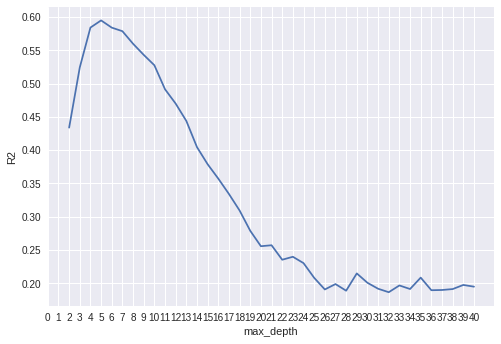

In [131]:
# Visualize which max_depth leads to the highest R^2 score
import matplotlib.pyplot as plt
plt.plot(max_depth_range, r2)
plt.xlabel('max_depth')
plt.ylabel('R2');
plt.xticks(np.arange(0,41, step=1));

From the graph above, the max_depth that gives the highest R^2 is 5.

# Decision Tree Regression

In [132]:
decTree_depth5 = DecisionTreeRegressor(max_depth=5, random_state = 42) 

In [133]:
pipe_decTree_depth5 = make_pipeline(col_transformer, decTree_depth5)

In [134]:
pipe_decTree_depth5.fit(X_train, y_train);

In [135]:
X_train.columns

Index(['Item_Fat_Content', 'Item_Visibility', 'Item_Type', 'Item_MRP',
       'Outlet_Establishment_Year', 'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')

In [136]:
train_decTree5_predict = pipe_decTree_depth5.predict(X_train)
test_decTree5_predict = pipe_decTree_depth5.predict(X_test)

# Decision Tree Metrics - R^2 optimized

Train Data

In [137]:
metrics_function(y_train, train_decTree5_predict)

RMSE = 1082.6656773340972
R^2 = 0.6039254897160836


Test Data

In [138]:
metrics_function(y_test, test_decTree5_predict)

RMSE = 1057.3947626960721
R^2 = 0.5947470502499344


R^2 is 59.5% on the test data which is 2% lower than the R^2 determined in the linear regresion model. The RMSE on the test data is also lower than linear regression model. (1057 < 1084) The optimized decision tree is chosen as the best model.

# Features Importance

In [62]:
columns = X_test.columns
columns

Index(['Item_Fat_Content', 'Item_Visibility', 'Item_Type', 'Item_MRP',
       'Outlet_Establishment_Year', 'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')

In [63]:
importance = dec_tree.feature_importances_
importance

array([0.00277979, 0.00641547, 0.00518739, 0.00406737, 0.00380916,
       0.0046803 , 0.00569316, 0.00631528, 0.00897686, 0.00227009,
       0.00412072, 0.00721984, 0.00415314, 0.00238727, 0.00119456,
       0.00830508, 0.00474606, 0.0030389 , 0.00580529, 0.00631737,
       0.00251879, 0.1938438 , 0.00308905, 0.00290469, 0.06018498,
       0.1267026 , 0.466077  , 0.047196  ])

In [139]:
#X = df.drop(columns=['Item_Outlet_Sales', 'Item_Identifier', 'Item_Weight', 'Outlet_Identifier', 'Outlet_Size']) #features - also dropping Outlet_Size because 25% of the data is missing in this column with no way to determine with any precision what it is

cat_data = X[cat_selector(X)]

In [65]:
ohe_encoder.fit(cat_data)

OneHotEncoder(handle_unknown='ignore', sparse=False)

In [66]:
cat_ohe = ohe_encoder.transform(cat_data)
cat_ohe

array([[1., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       ...,
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 1., 0., 0.]])

In [67]:
OneHot = pd.DataFrame(cat_ohe, columns=ohe_encoder.get_feature_names(cat_data.columns))
result = X_train.join(OneHot)
columns = result.columns
columns_final = columns.drop(['Outlet_Type', 'Outlet_Location_Type', 'Item_Fat_Content', 'Item_Type'])
columns_final

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Index(['Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year',
       'Item_Fat_Content_Low Fat', 'Item_Fat_Content_Regular',
       'Item_Type_Baking Goods', 'Item_Type_Breads', 'Item_Type_Breakfast',
       'Item_Type_Canned', 'Item_Type_Dairy', 'Item_Type_Frozen Foods',
       'Item_Type_Fruits and Vegetables', 'Item_Type_Hard Drinks',
       'Item_Type_Health and Hygiene', 'Item_Type_Household', 'Item_Type_Meat',
       'Item_Type_Others', 'Item_Type_Seafood', 'Item_Type_Snack Foods',
       'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods',
       'Outlet_Location_Type_Tier 1', 'Outlet_Location_Type_Tier 2',
       'Outlet_Location_Type_Tier 3', 'Outlet_Type_Grocery Store',
       'Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type2',
       'Outlet_Type_Supermarket Type3'],
      dtype='object')

In [68]:
importance.shape

(28,)

In [69]:
columns_final.shape

(28,)

In [70]:
combo = pd.Series(importance, columns_final)
combo

Item_Visibility                    0.002780
Item_MRP                           0.006415
Outlet_Establishment_Year          0.005187
Item_Fat_Content_Low Fat           0.004067
Item_Fat_Content_Regular           0.003809
Item_Type_Baking Goods             0.004680
Item_Type_Breads                   0.005693
Item_Type_Breakfast                0.006315
Item_Type_Canned                   0.008977
Item_Type_Dairy                    0.002270
Item_Type_Frozen Foods             0.004121
Item_Type_Fruits and Vegetables    0.007220
Item_Type_Hard Drinks              0.004153
Item_Type_Health and Hygiene       0.002387
Item_Type_Household                0.001195
Item_Type_Meat                     0.008305
Item_Type_Others                   0.004746
Item_Type_Seafood                  0.003039
Item_Type_Snack Foods              0.005805
Item_Type_Soft Drinks              0.006317
Item_Type_Starchy Foods            0.002519
Outlet_Location_Type_Tier 1        0.193844
Outlet_Location_Type_Tier 2     

# K Nearest Neighbors Regression

In [71]:
knn = KNeighborsRegressor(n_neighbors = 2)
pipe_knn = make_pipeline(col_transformer, knn)
pipe_knn.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f47a53ef710>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f47a53ef750>)])),
                ('kneighborsregressor', KNeighborsRegressor(n_neighbors=2))])

In [72]:
preds_knn = pipe_knn.predict(X_train)
metrics_function(y_train, preds_knn)

RMSE = 788.9033203613131
R^2 = 0.7897017184865524


In [73]:
preds_knn = pipe_knn.predict(X_test)
metrics_function(y_test, preds_knn)

RMSE = 1285.7009950133106
R^2 = 0.4008551444465319


In [74]:
len(y_train)


6392

In [75]:
rmse_val = [] # to store rmse values for different k   Source: https://www.analyticsvidhya.com/blog/2018/08/k-nearest-neighbor-introduction-regression-python/
for K in range(150):
    K = K+1
    knn1 = KNeighborsRegressor(n_neighbors=K)
    pipe_knn1 = make_pipeline(col_transformer, knn1)
    pipe_knn1.fit(X_train, y_train)
    K_pred=pipe_knn1.predict(X_test) # make prediction on test set
    error = sqrt(mean_squared_error(y_test,K_pred)) # calculate rmse
    rmse_val.append(error) # store rmse values
    #print('RMSE value for k= ' , K , 'is:', error)

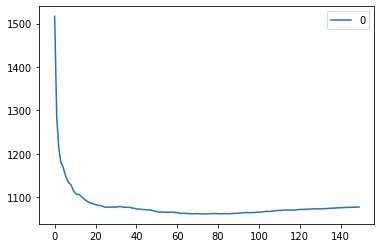

In [76]:
# plotting the rmse values against K values
curve = pd.DataFrame(rmse_val) 
curve.plot()

In [77]:
knn70 = KNeighborsRegressor(n_neighbors = 70) # use 70 for optimized K
pipe_knn70 = make_pipeline(col_transformer, knn70)
pipe_knn70.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f47a53ef710>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f47a53ef750>)])),
                ('kneighborsregressor', KNeighborsRegressor(n_neighbors=70))])

In [78]:
preds_knn70 = pipe_knn70.predict(X_train)
metrics_function(y_train, preds_knn70)

RMSE = 1104.8860250458868
R^2 = 0.5875007939890777


In [79]:
preds_knn70 = pipe_knn70.predict(X_test)
metrics_function(y_test, preds_knn70)

RMSE = 1062.3305431301271
R^2 = 0.5909548846760068


The optimized decision tree is still the best model after evaluating the model based on KNN. (R^2 tree > R^2 KNN) 59.5% > 59.2%. The RMSE on the test data decision tree is also lower than the KNN model. (1057 < 1061).

# Analysis on Features

In [80]:
df["Item_Weight"] = df.groupby("Item_Type").transform(lambda x: x.fillna(x.mean())) #5 Fill in missing values in the Item_Weight column by taking the mean of the Item_Type groups and filling them in to each corresponding missing Item_Weight
df.head(8) # I chose to fill in missing weights with average weight of each Item_Type group because similar food types tend to have relatively close weights

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30000,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92000,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50000,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20000,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93000,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
5,FDP36,10.39500,Regular,0.000000,Baking Goods,51.4008,OUT018,2009,Medium,Tier 3,Supermarket Type2,556.6088
6,FDO10,13.65000,Regular,0.012741,Snack Foods,57.6588,OUT013,1987,High,Tier 3,Supermarket Type1,343.5528
7,FDP10,12.98788,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636


In [81]:
#8 For any numerical columns, obtain the summary statistics of each (min, max, mean)
df[["Item_Weight", "Item_Visibility", 'Item_MRP', 'Outlet_Establishment_Year', 'Item_Outlet_Sales']].min()



Item_Weight                     4.555
Item_Visibility                 0.000
Item_MRP                       31.290
Outlet_Establishment_Year    1985.000
Item_Outlet_Sales              33.290
dtype: float64

In [82]:
df[["Item_Weight", "Item_Visibility", 'Item_MRP', 'Outlet_Establishment_Year', 'Item_Outlet_Sales']].max()



Item_Weight                     21.350000
Item_Visibility                  0.328391
Item_MRP                       266.888400
Outlet_Establishment_Year     2009.000000
Item_Outlet_Sales            13086.964800
dtype: float64

In [83]:
df[["Item_Weight", "Item_Visibility", 'Item_MRP', 'Outlet_Establishment_Year', 'Item_Outlet_Sales']].mean()


Item_Weight                    12.857890
Item_Visibility                 0.066132
Item_MRP                      140.992782
Outlet_Establishment_Year    1997.831867
Item_Outlet_Sales            2181.288914
dtype: float64

In [84]:
df[["Item_Weight", "Item_Visibility", 'Item_MRP', 'Outlet_Establishment_Year', 'Item_Outlet_Sales']].describe()
#alternate method for finding statistics on multiple columns

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857890,0.066132,140.992782,1997.831867,2181.288914
std,4.232804,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,9.310000,0.026989,93.826500,1987.000000,834.247400
50%,12.867061,0.053931,143.012800,1999.000000,1794.331000
75%,16.000000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


Part 3:

In [85]:
s = df['Item_Type'].value_counts()
s.head()

Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Name: Item_Type, dtype: int64

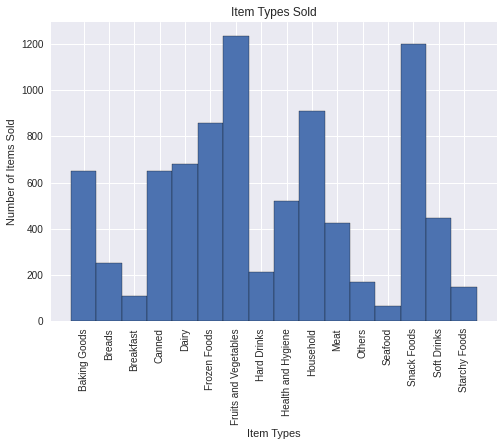

In [86]:
plt.style.use('seaborn')

plt.title('Item Types Sold')
plt.xlabel('Item Types')
plt.xticks(rotation=90)
plt.ylabel('Number of Items Sold')
sorted_items = df['Item_Type'].sort_values()
sorted_items.hist(bins = range(17), edgecolor = 'black', align = 'left');


In [87]:
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

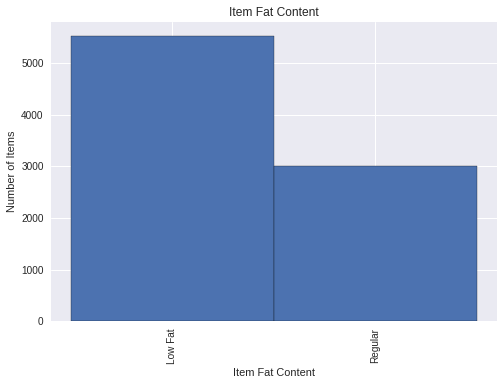

In [88]:
plt.style.use('seaborn')

plt.title('Item Fat Content')
plt.xlabel('Item Fat Content')
plt.xticks(rotation=90)
plt.ylabel('Number of Items')

df['Item_Fat_Content'].hist(bins = range(3), edgecolor = 'black', align = 'left');


Text(0, 0.5, 'Item Outlet Sales')

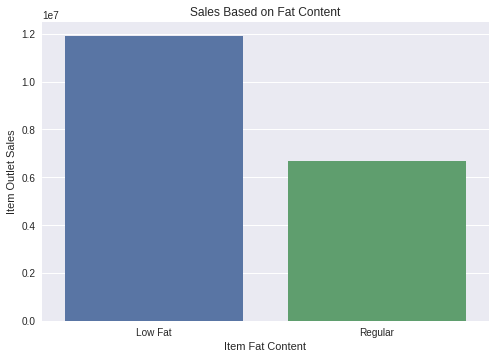

In [89]:
plt.style.use('seaborn')


fatContent_sales = df.groupby(['Item_Fat_Content'])[['Item_Outlet_Sales']].sum().reset_index()
sns.barplot(data = fatContent_sales, x = 'Item_Fat_Content', y = 'Item_Outlet_Sales');

plt.title('Sales Based on Fat Content')
plt.xlabel('Item Fat Content')
plt.ylabel('Item Outlet Sales')


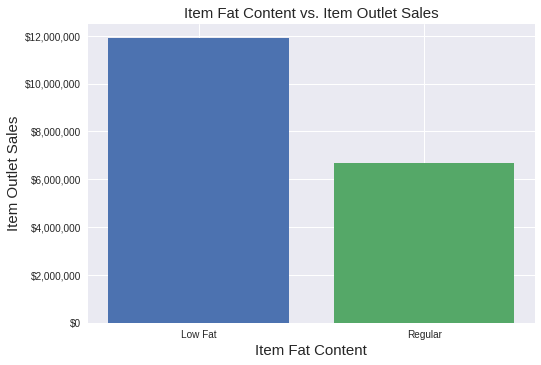

In [90]:
#plot 

plt.style.use('seaborn')
fig, ax = plt.subplots()
x = fatContent_sales['Item_Fat_Content']
y = fatContent_sales['Item_Outlet_Sales']
ax.bar(x, y, color = sns.color_palette())

ax.set_xlabel("Item Fat Content", fontsize = 15)
ax.set_ylabel("Item Outlet Sales", fontsize = 15)
ax.set_title("Item Fat Content vs. Item Outlet Sales", fontsize = 15)

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)

plt.show()

Text(0.5, 1.0, 'Sales per Item Type')

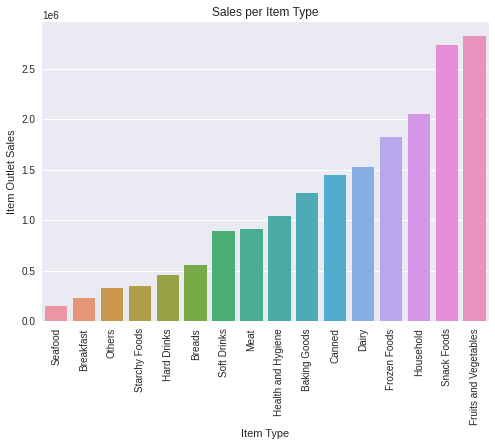

In [91]:
salesBy_type = df.groupby(['Item_Type'])[['Item_Outlet_Sales']].sum().reset_index()
salesBy_type = salesBy_type.sort_values(by = ['Item_Outlet_Sales'])
sns.barplot(data = salesBy_type, x = 'Item_Type', y = 'Item_Outlet_Sales');

plt.xticks(rotation = 90)
plt.xlabel('Item Type')
plt.ylabel('Item Outlet Sales')
plt.title('Sales per Item Type')

Text(0.5, 1.0, 'Sales per Outlet Type')

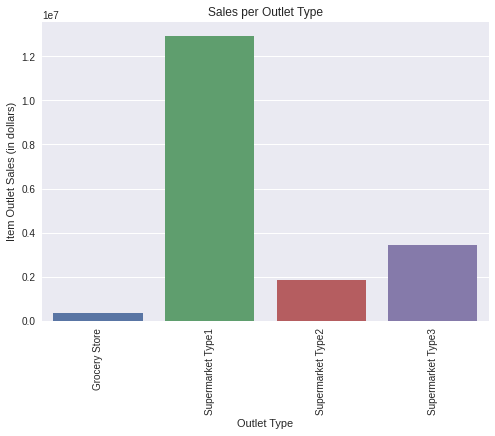

In [92]:
outlet_sales = df.groupby(['Outlet_Type'])[['Item_Outlet_Sales']].sum().reset_index()
sns.barplot(data = outlet_sales, x = 'Outlet_Type', y = 'Item_Outlet_Sales');

plt.xticks(rotation = 90)
plt.xlabel('Outlet Type')
plt.ylabel('Item Outlet Sales (in dollars)')
plt.title('Sales per Outlet Type')

Text(0.5, 1.0, 'Average Sales per Outlet Type')

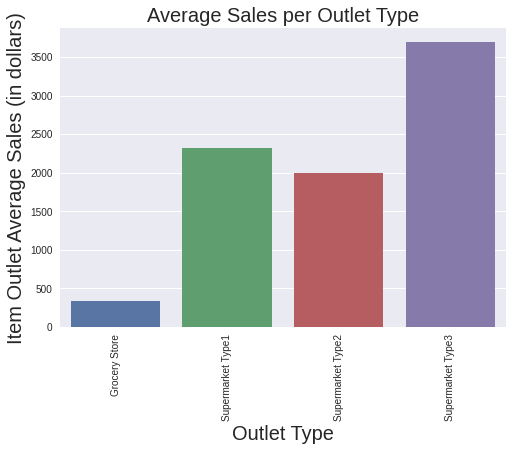

In [93]:
outlet_sales = df.groupby(['Outlet_Type'])[['Item_Outlet_Sales']].mean().reset_index()
sns.barplot(data = outlet_sales, x = 'Outlet_Type', y = 'Item_Outlet_Sales');

plt.xticks(rotation = 90)
plt.xlabel('Outlet Type', fontsize = 20)
plt.ylabel('Item Outlet Average Sales (in dollars)', fontsize = 20)
plt.title('Average Sales per Outlet Type', fontsize = 20)

Text(0.5, 1.0, 'Sales per Item Type at all Supermarket Type1 Locations')

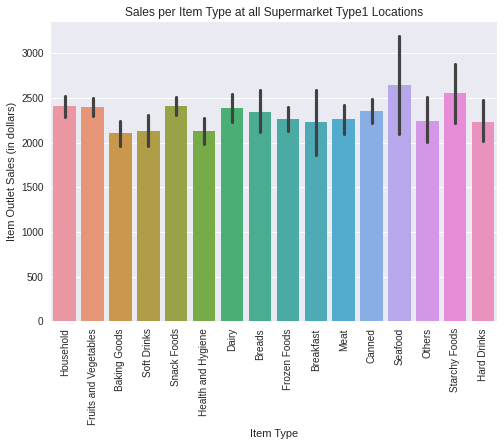

In [94]:
smkt_1 = df['Outlet_Type']=='Supermarket Type1'
market1_filter = df.loc[smkt_1,:]
market1_filter = market1_filter.sort_values(by = 'Item_Outlet_Sales')

sns.barplot(data = market1_filter, x = 'Item_Type', y = 'Item_Outlet_Sales');

plt.xticks(rotation = 90)
plt.xlabel('Item Type')
plt.ylabel('Item Outlet Sales (in dollars)')
plt.title('Sales per Item Type at all Supermarket Type1 Locations')

Text(0.5, 1.0, 'Sales per Outlet Location')

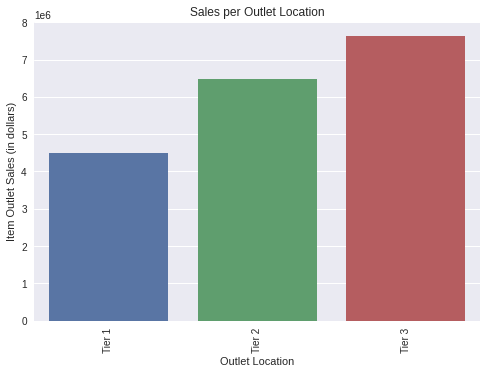

In [95]:
location_sales = df.groupby(['Outlet_Location_Type'])[['Item_Outlet_Sales']].sum().reset_index()
sns.barplot(data = location_sales, x = 'Outlet_Location_Type', y = 'Item_Outlet_Sales');
plt.xticks(rotation = 90)

plt.xlabel('Outlet Location')
plt.ylabel('Item Outlet Sales (in dollars)')
plt.title('Sales per Outlet Location')


Text(0.5, 1.0, 'Average Sales per Outlet Location')

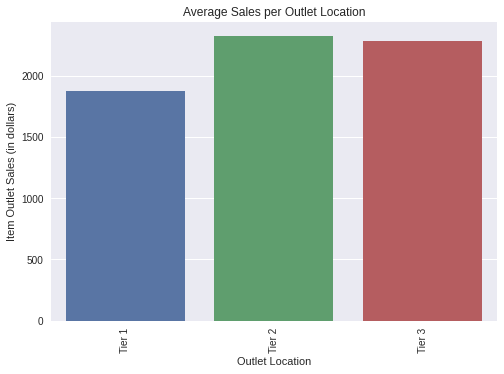

In [96]:
location_sales = df.groupby(['Outlet_Location_Type'])[['Item_Outlet_Sales']].mean().reset_index()
sns.barplot(data = location_sales, x = 'Outlet_Location_Type', y = 'Item_Outlet_Sales');
plt.xticks(rotation = 90)

plt.xlabel('Outlet Location')
plt.ylabel('Item Outlet Sales (in dollars)')
plt.title('Average Sales per Outlet Location')

Text(0.5, 1.0, 'Item Visibility vs. Item Outlet Sales')

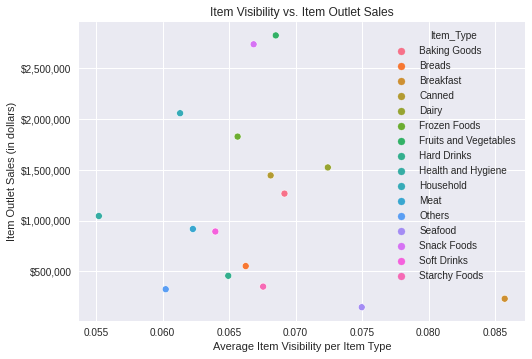

In [97]:
type_visibility = df.groupby(['Item_Type'])[['Item_Visibility']].mean()
type_sales = df.groupby(['Item_Type'])[['Item_Outlet_Sales']].sum()
visibility_sales = pd.concat([type_visibility.Item_Visibility, type_sales.Item_Outlet_Sales], axis =1 )
scatter = sns.scatterplot(x = 'Item_Visibility', y = 'Item_Outlet_Sales', data = visibility_sales, hue = 'Item_Type');

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
scatter.yaxis.set_major_formatter(tick)

plt.xlabel('Average Item Visibility per Item Type')
plt.ylabel('Item Outlet Sales (in dollars)')
plt.title('Item Visibility vs. Item Outlet Sales')

Text(0, 0.5, 'Item Outlet Sales')

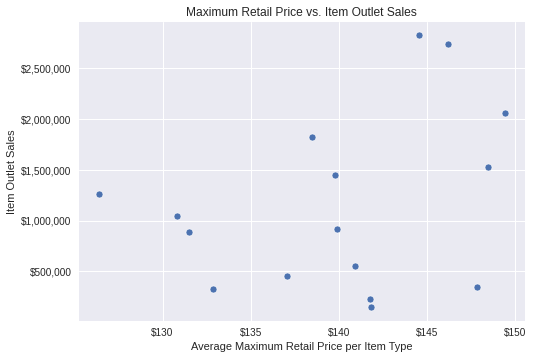

In [98]:
MRP_type = df.groupby(['Item_Type'])[["Item_MRP"]].mean()
MRP_sales = pd.concat([type_sales.Item_Outlet_Sales, MRP_type.Item_MRP], axis = 1)
scatter = sns.scatterplot(x = 'Item_MRP', y = 'Item_Outlet_Sales', data = MRP_sales)
scatter

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
scatter.yaxis.set_major_formatter(tick)
scatter.xaxis.set_major_formatter(tick)

plt.title('Maximum Retail Price vs. Item Outlet Sales')
plt.xlabel('Average Maximum Retail Price per Item Type')
plt.ylabel('Item Outlet Sales')

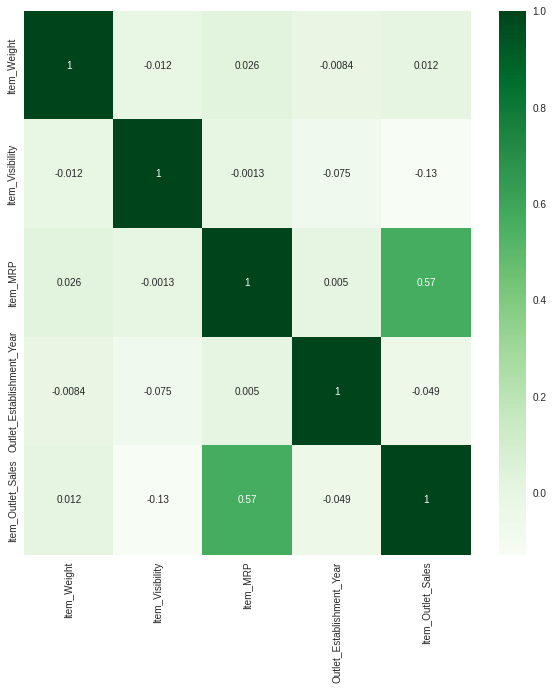

In [99]:
corr = df.corr()
plt.figure(figsize = (10,10))
sns.heatmap(corr, cmap = 'Greens' , annot = True)

In [100]:
t1_filter = df['Outlet_Type']== 'Supermarket Type1'
t2_filter = df['Outlet_Type']== 'Supermarket Type2'
t3_filter = df['Outlet_Type']== 'Supermarket Type3'
gro_filter = df['Outlet_Type'] == 'Grocery Store'

t1_df = df.loc[t1_filter]
t2_df = df.loc[t2_filter]
t3_df = df.loc[t3_filter]
gro_df = df.loc[gro_filter]
gro_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
3,FDX07,19.200000,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
23,FDC37,12.277108,Low Fat,0.057557,Baking Goods,107.6938,OUT019,1985,Small,Tier 1,Grocery Store,214.3876
28,FDE51,5.925000,Regular,0.161467,Dairy,45.5086,OUT010,1998,NaN,Tier 3,Grocery Store,178.4344
29,FDC14,12.305705,Regular,0.072222,Canned,43.6454,OUT019,1985,Small,Tier 1,Grocery Store,125.8362
30,FDV38,19.250000,Low Fat,0.170349,Dairy,55.7956,OUT010,1998,NaN,Tier 3,Grocery Store,163.7868


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'Item Outlet Sales at Each Supermarket Type')

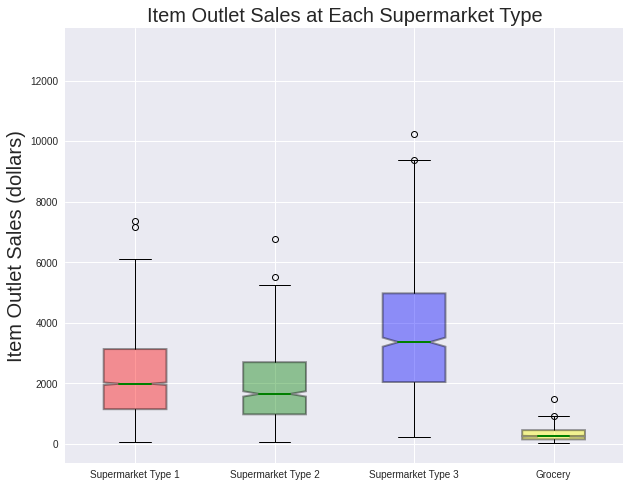

In [101]:

fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (10,8)) #Creates subplots out of the boxplots



boxplots = axes.boxplot([t1_df['Item_Outlet_Sales'], t2_df['Item_Outlet_Sales'], t3_df['Item_Outlet_Sales'], gro_df['Item_Outlet_Sales']], notch = True,
           labels = ['Supermarket Type 1', 'Supermarket Type 2', 'Supermarket Type 3', "Grocery"], 
           patch_artist = True, 
           medianprops = dict(linestyle='-', linewidth=2, color='green'),
           boxprops = dict(linestyle='--', linewidth=2, color='Black',  facecolor = 'yellow', alpha = .4));

fliers = boxplots['fliers'] #list of fliers outside boxplot

for fly in fliers: #pick out minimum and maximum flier data points and plot on graph
    fdata = fly.get_data()
    fly.set_data([fdata[0][0],fdata[0][-1]],[fdata[1][0],fdata[1][-1]])


boxplot1 = boxplots['boxes'][0] #save the location of the first boxplot on the left to a variable boxplot1
boxplot2 = boxplots['boxes'][1]
boxplot3 = boxplots['boxes'][2]

boxplot1.set_facecolor('red') #color boxplot1 red
boxplot2.set_facecolor('green') #color boxplot2 green
boxplot3.set_facecolor('blue')
plt.ylabel('Item Outlet Sales (dollars)', fontsize = 20);
plt.title('Item Outlet Sales at Each Supermarket Type', fontsize = 20)



These boxplots show the distribution of sales for product categories at each of the four types of Supermarkets. Type 3 Supermarkets had the highest median, maximum and range of sales. Type 1 Supermarkets ranked the next highest for median, maximum and range of sales and Grocery Stores ranked least in median, maximum and range of item sales.

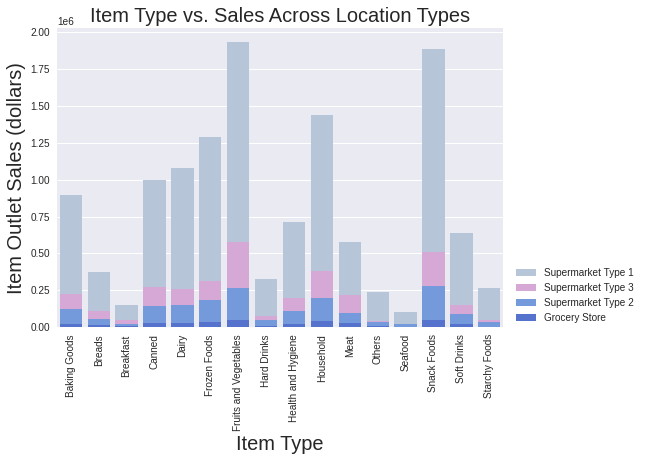

In [102]:
t1_items_sales = t1_df.groupby(['Item_Type'])[['Item_Outlet_Sales']].sum().reset_index()
gro_items_sales = gro_df.groupby(['Item_Type'])[['Item_Outlet_Sales']].sum().reset_index()
t3_items_sales = t3_df.groupby(['Item_Type'])[['Item_Outlet_Sales']].sum().reset_index()
t2_items_sales = t2_df.groupby(['Item_Type'])[['Item_Outlet_Sales']].sum().reset_index()

s1 = sns.barplot(data = t1_items_sales, x = 'Item_Type', y = 'Item_Outlet_Sales', color = 'lightsteelblue', label = 'Supermarket Type 1')
s2 = sns.barplot(data = t3_items_sales, x = 'Item_Type', y = 'Item_Outlet_Sales', color = 'plum', label = 'Supermarket Type 3')
s3 = sns.barplot(data = t2_items_sales, x = 'Item_Type', y = 'Item_Outlet_Sales', color = 'cornflowerblue', label = 'Supermarket Type 2')
s4 = sns.barplot(data = gro_items_sales, x = 'Item_Type', y = 'Item_Outlet_Sales', color = 'royalblue', label = 'Grocery Store')

plt.xticks(rotation = 90)
plt.xlabel('Item Type', fontsize =20)
plt.ylabel('Item Outlet Sales (dollars)', fontsize =20)
plt.title('Item Type vs. Sales Across Location Types', fontsize =20)
plt.legend( loc = (1.02, 0))
plt.show()


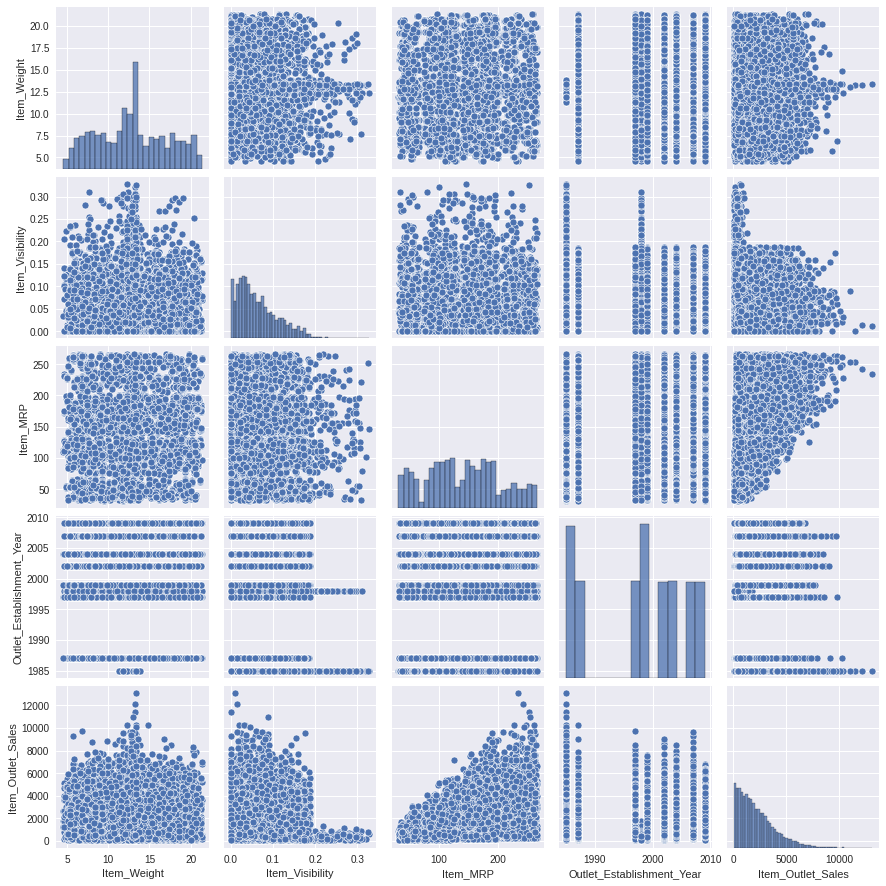

In [103]:
sns.pairplot(df)

Text(0.5, 1.0, 'Maximum Retail Price vs. Item Outlet Sales')

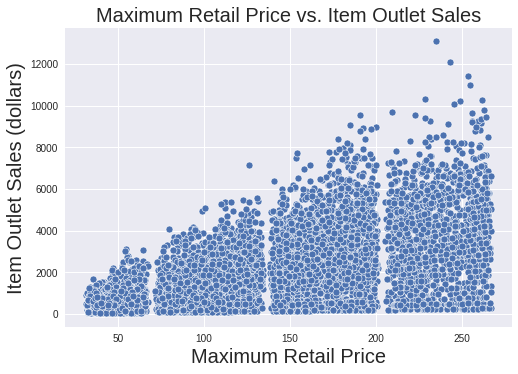

In [104]:
scatter = sns.scatterplot(x = 'Item_MRP', y = 'Item_Outlet_Sales', data = df);
plt.ylabel('Item Outlet Sales (dollars)', fontsize = 20)
plt.xlabel('Maximum Retail Price', fontsize = 20)
plt.title('Maximum Retail Price vs. Item Outlet Sales', fontsize = 20)

There exists a positive relationship between Manufacturer Retail Price and Item Outlet Sales.

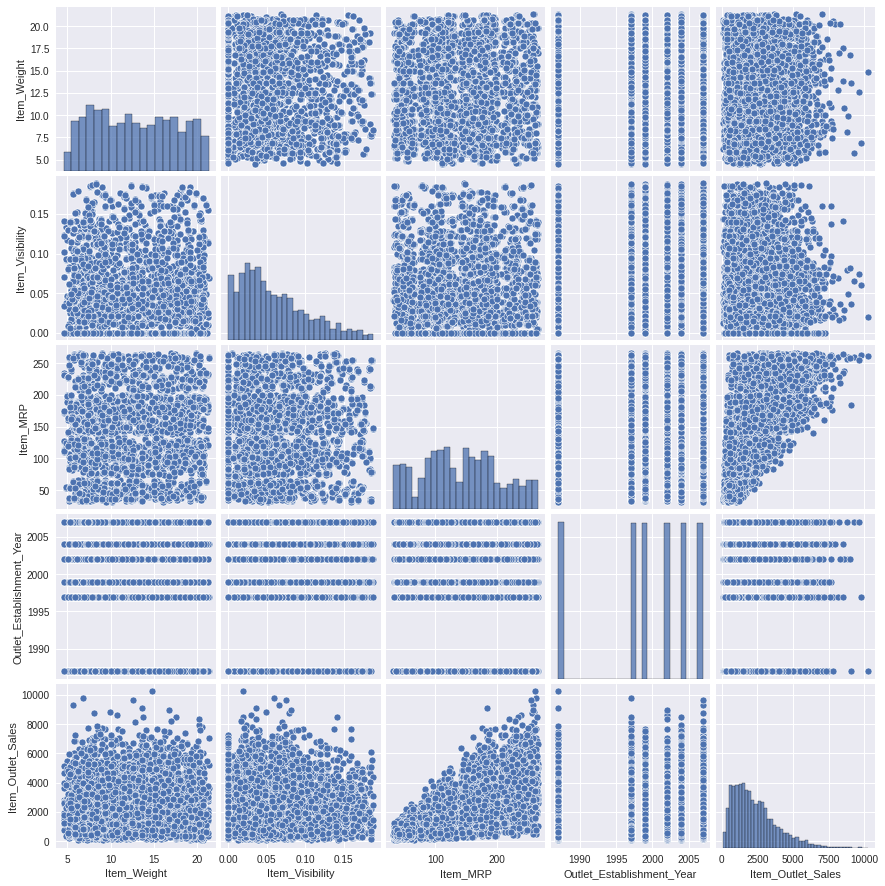

In [105]:
sns.pairplot(t1_df)

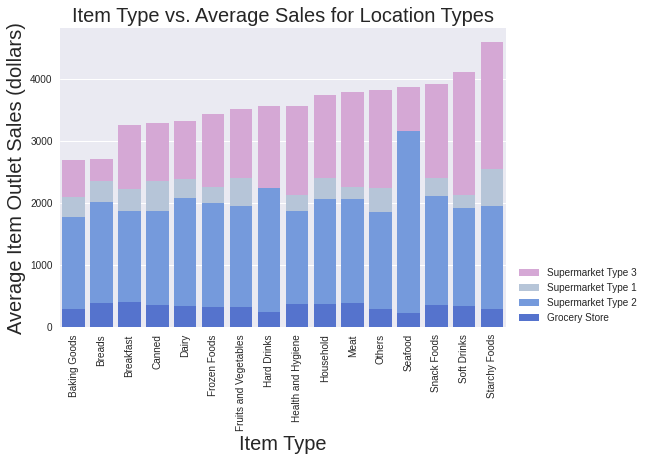

In [106]:
t1_items_sales = t1_df.groupby(['Item_Type'])[['Item_Outlet_Sales']].mean().reset_index()
gro_items_sales = gro_df.groupby(['Item_Type'])[['Item_Outlet_Sales']].mean().reset_index()
t3_items_sales = t3_df.groupby(['Item_Type'])[['Item_Outlet_Sales']].mean().reset_index()
t3_sort = t3_items_sales.sort_values(by ='Item_Outlet_Sales')
t2_items_sales = t2_df.groupby(['Item_Type'])[['Item_Outlet_Sales']].mean().reset_index()
t2_sort = t2_items_sales.sort_values(by = 'Item_Outlet_Sales')
s2 = sns.barplot(data = t3_sort, x = 'Item_Type', y = 'Item_Outlet_Sales', color = 'plum', label = 'Supermarket Type 3')
s1 = sns.barplot(data = t1_items_sales, x = 'Item_Type', y = 'Item_Outlet_Sales', color = 'lightsteelblue', label = 'Supermarket Type 1')
s3 = sns.barplot(data = t2_items_sales, x = 'Item_Type', y = 'Item_Outlet_Sales', color = 'cornflowerblue', label = 'Supermarket Type 2')
s4 = sns.barplot(data = gro_items_sales, x = 'Item_Type', y = 'Item_Outlet_Sales', color = 'royalblue', label = 'Grocery Store')

plt.xticks(rotation = 90)
plt.xlabel('Item Type', fontsize =20)
plt.ylabel('Average Item Outlet Sales (dollars)', fontsize =20)
plt.title('Item Type vs. Average Sales for Location Types', fontsize =20)
plt.legend( loc = (1.02, 0))
plt.show()

Text(0.5, 1.0, 'Item Type vs. Average Sales for Location Types')

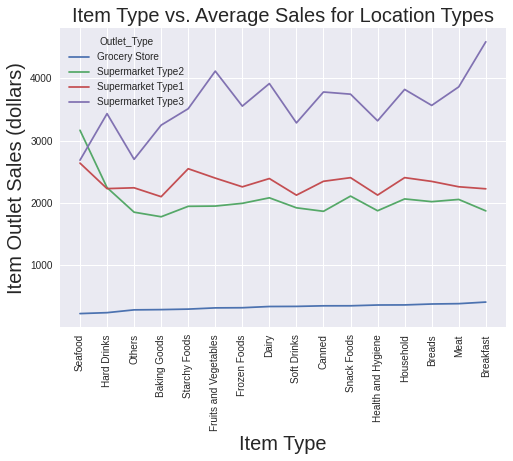

In [107]:
dfg = df.groupby(['Item_Type', 'Outlet_Type']).mean({'Item_Outlet_Sales'}).sort_values(by='Item_Outlet_Sales').reset_index() #source:  https://stackoverflow.com/questions/41494942/pandas-dataframe-groupby-plot/56652699
sns.lineplot(x='Item_Type', y='Item_Outlet_Sales', data=dfg, hue='Outlet_Type')

plt.xticks(rotation = 90)
plt.xlabel('Item Type', fontsize =20)
plt.ylabel('Item Outlet Sales (dollars)', fontsize =20)
plt.title('Item Type vs. Average Sales for Location Types', fontsize =20)


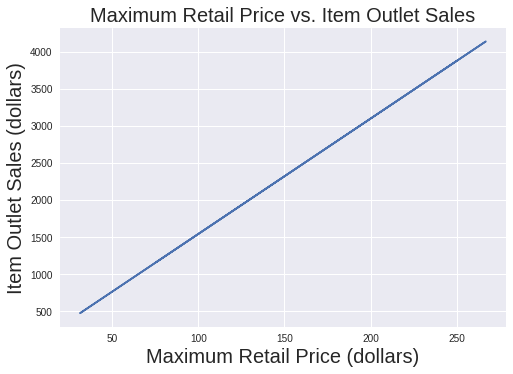

In [108]:
x = df['Item_MRP']
y = df['Item_Outlet_Sales']

# obtain m (slope) and b (y-intercept) of linear regression line
m, b = np.polyfit(x, y, 1)

# add linear regression line to scatterplot 
plt.plot(x, m*x+b)
plt.xlabel('Maximum Retail Price (dollars)', fontsize =20)
plt.ylabel('Item Outlet Sales (dollars)', fontsize =20)
plt.title('Maximum Retail Price vs. Item Outlet Sales', fontsize =20)
plt.show()